In [302]:
# going to dev json to sql with spark using local json file. Then implement on ec2 instance for pipeining. 
import pyspark as ps
import pandas as pd
from pyspark.sql.functions import lit
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )
sc = spark.sparkContext

In [3]:
# loaded test df (COVID only CO)
df = spark.read.format('json').load("../zip_data/data/test.json")

In [4]:
df.columns

['contributors',
 'coordinates',
 'created_at',
 'display_text_range',
 'entities',
 'extended_entities',
 'extended_tweet',
 'favorite_count',
 'favorited',
 'filter_level',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'limit',
 'place',
 'possibly_sensitive',
 'quote_count',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'reply_count',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'timestamp_ms',
 'truncated',
 'user',
 'withheld_in_countries']

In [5]:
# subsect colums that I want for 'tweets' table
tweet_col_lst = ['id','user','lang','entities','place','created_at','text','source']
tweet_col_df = df[tweet_col_lst]

In [6]:
tweet_col_df.show(1)

+-------------------+--------------------+----+--------------------+-----+--------------------+--------------------+--------------------+
|                 id|                user|lang|            entities|place|          created_at|                text|              source|
+-------------------+--------------------+----+--------------------+-----+--------------------+--------------------+--------------------+
|1245439863907852289|[false, Mon Feb 2...|  en|[[],, [], [], [[1...| null|Wed Apr 01 19:56:...|RT @ChristinePolo...|<a href="http://t...|
+-------------------+--------------------+----+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 1 row



In [7]:
tweet_col_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- contributors_enabled: boolean (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- default_profile: boolean (nullable = true)
 |    |-- default_profile_image: boolean (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- follow_request_sent: string (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- following: string (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- geo_enabled: boolean (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- is_translator: boolean (nullable = true)
 |    |-- lang: string (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- notifications: string (nullable = true)
 |    |

In [8]:
tweet_col_df.cache()
tweet_col_df.count()

5005

In [9]:
tweet_col_df=tweet_col_df.withColumn('state',lit('co'))
tweet_col_df=tweet_col_df.withColumn('search_term_key',lit(1))
tweet_col_df['state']

Column<b'state'>

In [10]:
tweet_col_df.createOrReplaceTempView('tweets')

In [11]:

place = spark.sql('''
    SELECT
        place.`full_name` AS geo_name,
        state,
        search_term
    FROM
        tweets
    WHERE
        (place.`full_name` IS NOT NULL AND
        lang = 'en')
    ''')
print(type(place))
place.show(20)

AnalysisException: "cannot resolve '`search_term`' given input columns: [tweets.created_at, tweets.entities, tweets.lang, tweets.id, tweets.search_term_key, tweets.user, tweets.text, tweets.source, tweets.place, tweets.state]; line 5 pos 8;\n'Project [place#27.full_name AS geo_name#245, state#224, 'search_term]\n+- Filter (isnotnull(place#27.full_name) && (lang#25 = en))\n   +- SubqueryAlias `tweets`\n      +- Project [id#17L, user#42, lang#25, entities#10, place#27, created_at#8, text#39, source#38, state#224, 1 AS search_term_key#234]\n         +- Project [id#17L, user#42, lang#25, entities#10, place#27, created_at#8, text#39, source#38, co AS state#224]\n            +- Project [id#17L, user#42, lang#25, entities#10, place#27, created_at#8, text#39, source#38]\n               +- Relation[contributors#6,coordinates#7,created_at#8,display_text_range#9,entities#10,extended_entities#11,extended_tweet#12,favorite_count#13L,favorited#14,filter_level#15,geo#16,id#17L,id_str#18,in_reply_to_screen_name#19,in_reply_to_status_id#20L,in_reply_to_status_id_str#21,in_reply_to_user_id#22L,in_reply_to_user_id_str#23,is_quote_status#24,lang#25,limit#26,place#27,possibly_sensitive#28,quote_count#29L,... 14 more fields] json\n"

In [ ]:
place.printSchema()

In [12]:
#perform SQL queries to make the tables I want, first tweets table

temp = tweet_col_df.createOrReplaceTempView('tweets')

tweet_tbl = spark.sql('''
    SELECT 
        id AS tweet_id,
        state,
        search_term_key,
        user.`id` AS user_id,
        created_at AS time_created,
        text AS tweet_text,
        source,
        place.`full_name` AS geo_name,
        place.`id` AS geo_id,
        place.`bounding_box`.`coordinates`[0][0][1] AS geo_coords_SW_lat,
        place.`bounding_box`.`coordinates`[0][0][0] AS geo_coords_SW_long,
        place.`bounding_box`.`coordinates`[0][2][1] AS geo_coords_NE_lat,
        place.`bounding_box`.`coordinates`[0][2][0] AS geo_coords_NE_long,
        entities.`hashtags`[0].`text` AS hash_tag_1,
        entities.`hashtags`[1].`text` AS hash_tag_2,
        entities.`hashtags`[2].`text` AS hash_tag_3,
        entities.`hashtags`[3].`text` AS hash_tag_4,
        entities.`hashtags`[4].`text` AS hash_tags_5,
        entities.`user_mentions`[0].`screen_name` AS user_mentions_1,
        entities.`user_mentions`[1].`screen_name` AS user_mentions_2,
        entities.`user_mentions`[2].`screen_name` AS user_mentions_3,
        entities.`user_mentions`[3].`screen_name` AS user_mentions_4,
        entities.`user_mentions`[4].`screen_name` AS user_mentions_5,
        user.`created_at` AS user_date_created,
        user.`location` AS location,
        user.`description` AS description
    FROM tweets
    WHERE
        lang = 'en'
    ''')


In [13]:
spark_schema = tweet_tbl.schema
tweet_tbl.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- state: string (nullable = false)
 |-- search_term_key: integer (nullable = false)
 |-- user_id: long (nullable = true)
 |-- time_created: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- source: string (nullable = true)
 |-- geo_name: string (nullable = true)
 |-- geo_id: string (nullable = true)
 |-- geo_coords_SW_lat: double (nullable = true)
 |-- geo_coords_SW_long: double (nullable = true)
 |-- geo_coords_NE_lat: double (nullable = true)
 |-- geo_coords_NE_long: double (nullable = true)
 |-- hash_tag_1: string (nullable = true)
 |-- hash_tag_2: string (nullable = true)
 |-- hash_tag_3: string (nullable = true)
 |-- hash_tag_4: string (nullable = true)
 |-- hash_tags_5: string (nullable = true)
 |-- user_mentions_1: string (nullable = true)
 |-- user_mentions_2: string (nullable = true)
 |-- user_mentions_3: string (nullable = true)
 |-- user_mentions_4: string (nullable = true)
 |-- user_mentions_5: string (null

In [14]:
pd_tweets = tweet_tbl.toPandas()

In [15]:
pd_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2767 entries, 0 to 2766
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2767 non-null   int64  
 1   state               2767 non-null   object 
 2   search_term_key     2767 non-null   int32  
 3   user_id             2767 non-null   int64  
 4   time_created        2767 non-null   object 
 5   tweet_text          2767 non-null   object 
 6   source              2767 non-null   object 
 7   geo_name            69 non-null     object 
 8   geo_id              69 non-null     object 
 9   geo_coords_SW_lat   69 non-null     float64
 10  geo_coords_SW_long  69 non-null     float64
 11  geo_coords_NE_lat   69 non-null     float64
 12  geo_coords_NE_long  69 non-null     float64
 13  hash_tag_1          1564 non-null   object 
 14  hash_tag_2          579 non-null    object 
 15  hash_tag_3          219 non-null    object 
 16  hash_t

In [16]:
tweet_date = pd_tweets['time_created']
tweet_date[0]

'Wed Apr 01 19:56:17 +0000 2020'

In [17]:
pd.to_datetime(tweet_date[0])

Timestamp('2020-04-01 19:56:17+0000', tz='UTC')

In [18]:
tweet_date_formated = tweet_date.map(lambda x: pd.to_datetime(x))

In [19]:
pd_tweets['state'].astype('string')

0       co
1       co
2       co
3       co
4       co
        ..
2762    co
2763    co
2764    co
2765    co
2766    co
Name: state, Length: 2767, dtype: string

In [20]:
pd_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2767 entries, 0 to 2766
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2767 non-null   int64  
 1   state               2767 non-null   object 
 2   search_term_key     2767 non-null   int32  
 3   user_id             2767 non-null   int64  
 4   time_created        2767 non-null   object 
 5   tweet_text          2767 non-null   object 
 6   source              2767 non-null   object 
 7   geo_name            69 non-null     object 
 8   geo_id              69 non-null     object 
 9   geo_coords_SW_lat   69 non-null     float64
 10  geo_coords_SW_long  69 non-null     float64
 11  geo_coords_NE_lat   69 non-null     float64
 12  geo_coords_NE_long  69 non-null     float64
 13  hash_tag_1          1564 non-null   object 
 14  hash_tag_2          579 non-null    object 
 15  hash_tag_3          219 non-null    object 
 16  hash_t

In [21]:
pd_tweets['geo_coords'][pd_tweets['geo_coords'].isna() == False]

KeyError: 'geo_coords'

In [22]:
print(pd_tweets['geo_coords'][34], pd_tweets['geo_coords_two'][34])

KeyError: 'geo_coords'

In [23]:
pd_tweets['geo_name'][34]

'Los Angeles, CA'

In [24]:
pd_tweets.head(5)

,tweet_id,state,search_term_key,user_id,time_created,tweet_text,source,geo_name,geo_id,geo_coords_SW_lat,...,hash_tag_4,hash_tags_5,user_mentions_1,user_mentions_2,user_mentions_3,user_mentions_4,user_mentions_5,user_date_created,location,description
0,1245439863907852289,co,1,968218684702560261,Wed Apr 01 19:56:17 +0000 2020,RT @ChristinePolon1: I just called this hospit...,"<a href=""http://twitter.com/download/android"" ...",None,None,NaN,...,None,None,ChristinePolon1,None,None,None,None,Mon Feb 26 20:18:17 +0000 2018,"Michigan, USA",#Truth #MAGA #KAG #Q #QAnon #GreatAwakening #...
1,1245439864130191362,co,1,41109216,Wed Apr 01 19:56:17 +0000 2020,RT @socialistworker: Hungary’s government effe...,"<a href=""http://twitter.com/download/android"" ...",None,None,NaN,...,None,None,socialistworker,None,None,None,None,Tue May 19 12:56:52 +0000 2009,London UK,I AM A CITIZEN OF THE WORLD 🌍\nI am a Globalis...
2,1245439864197218304,co,1,550338885,Wed Apr 01 19:56:17 +0000 2020,"RT @JustinBrannan: Dear @Amazon,\n\nWith peopl...","<a href=""https://mobile.twitter.com"" rel=""nofo...",None,None,NaN,...,None,None,JustinBrannan,amazon,None,None,None,Tue Apr 10 16:42:11 +0000 2012,None,I don’t know her.
3,1245439864331436032,co,1,1149028897247416320,Wed Apr 01 19:56:17 +0000 2020,UV DISINFECTION - UV LIGHT AND COVID-19 (CORON...,"<a href=""http://twitter.com/download/iphone"" r...",None,None,NaN,...,None,None,None,None,None,None,None,Wed Jul 10 18:53:31 +0000 2019,"Texas, USA","BSN RN OR/CVOR/IR/GI. Jesus is #1. 🚫DM, 🚫chats..."
4,1245439864943906817,co,1,1146317592556122112,Wed Apr 01 19:56:17 +0000 2020,RT @KemiOlunloyo: #BREAKING I am calling for ...,"<a href=""http://twitter.com/download/android"" ...",None,None,NaN,...,None,None,KemiOlunloyo,HE_HopeUzodimma,NCDCgov,Chikwe_I,None,Wed Jul 03 07:19:46 +0000 2019,None,A bio can't explain ME


In [25]:
tweet_text = pd_tweets[['tweet_text', 'description']]

In [26]:
tweet_text['pre_clean_length_text'] = [len(t) for t in tweet_text['tweet_text']]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
tweet_text.head(5)

,tweet_text,description,pre_clean_length_text
0,RT @ChristinePolon1: I just called this hospit...,#Truth #MAGA #KAG #Q #QAnon #GreatAwakening #...,140
1,RT @socialistworker: Hungary’s government effe...,I AM A CITIZEN OF THE WORLD 🌍\nI am a Globalis...,139
2,"RT @JustinBrannan: Dear @Amazon,\n\nWith peopl...",I don’t know her.,140
3,UV DISINFECTION - UV LIGHT AND COVID-19 (CORON...,"BSN RN OR/CVOR/IR/GI. Jesus is #1. 🚫DM, 🚫chats...",129
4,RT @KemiOlunloyo: #BREAKING I am calling for ...,A bio can't explain ME,140


In [28]:
tweet_text[tweet_text.pre_clean_length_text > 140]

,tweet_text,description,pre_clean_length_text
15,RT @RepJimBanks: Heartbreaking story about Ai ...,None,144
20,RT @Davidshal20: @pulte Due to #COVID19 known ...,Account parodia,148
29,RT @codepink: The people of #Iran are suffocat...,"writer, teacher, mom, cultural and political a...",144
51,RT @jazzzy_10: Due to #COVID19 aka #Coronaviru...,you have to be odd to be number one ~Dr. seuss,144
59,RT @PIB_India: Actor @Suriya_offl appeals peop...,@samsung SEC,144
...,...,...,...
2706,RT @PHLJazzProject: Just as I was putting toge...,“Philadelphia’s most reliable and ambitious pr...,144
2707,RT @TrinityResists: Trump &amp; his regime out...,"Progressive, Mom, Middle Class, Passionate Abo...",152
2713,RT @USAIDEthiopia: To support #COVID19 respons...,"Lecturer @ AAU, CHS, SOM\n\nInternational Medi...",144
2718,RT @MichaelMaidment: Hey #Ottawa. When you dec...,"Director Comms & Gov. Relations @UNHCRCanada, ...",143


In [29]:
tweet_text.tweet_text[15]

'RT @RepJimBanks: Heartbreaking story about Ai Fen, a Chinese doc who raised alarm about #COVID19 in early Dec &amp; is now missing.\n\n@StateDept…'

In [275]:
mask = tweet_text.tweet_text.str.contains(r"\w", na=False)
tweet_text.tweet_text.loc[mask]

0       RT @ChristinePolon1: I just called this hospit...
1       RT @socialistworker: Hungary’s government effe...
2       RT @JustinBrannan: Dear @Amazon,\n\nWith peopl...
3       UV DISINFECTION - UV LIGHT AND COVID-19 (CORON...
4       RT @KemiOlunloyo: #BREAKING  I am calling for ...
                              ...                        
2762    RT @AltafHussain_90: Dear President @realDonal...
2763    RT @DavidTRobins: @FoxNews spews lies. Hold th...
2764                     What is the first stimulus bill?
2765    @khamenei_ir \n@HassanRouhani \nWhat prosperit...
2766    RT @natureheals616: @the_resistor @washingtonp...
Name: tweet_text, Length: 2767, dtype: object

In [48]:
tweet_text.tweet_text[3]

'UV DISINFECTION - UV LIGHT AND COVID-19 (CORONAVIRUS) – UV Disinfection #SaveLives #COVID19 #Covid_19USA… https://t.co/CWspARIsGZ'

In [ ]:
t2 = re.sub(r'http\S+','',tweet_text.tweet_text[3])

In [163]:
negation_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negation_dic.keys()) + r')\b')
neg_pattern
from string import punctuation

In [178]:
text_abbs = { 'lol': 'laughing out loud', 'bfn': 'bye for now', 'cuz': 'because',
        'afk': 'away from keyboard', 'nvm': 'never mind', 'iirc': 'if i recall correctly',
        'ttyl': 'talk to you later', 'imho': 'in my honest opinion', 'brb': 'be right back' }

grammar_abbs = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
            "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
            "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
            "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
            "mustn't":"must not"}

In [351]:
test = [r'http\S+', r'&amp; ', r"[@#]", r"[!$%()*+,-./:;<=>?\^_`{|}~]"]
# print(test)    r'[^a-zA-Z]'
t1 = tweet_text.tweet_text[5].lower()
t2 = ' '.join([text_abbs.get(word,word) for word in t1.split()])
t2 = ' '.join([grammar_abbs.get(word,word) for word in t1.split()])
print(t2)

test2 = '|'.join([elem for elem in test])

t3 = re.sub(test2,' ',t2)
print(t3)

t4 = re.sub(r'\W',' ',t3).split()
print(t4)
# t5 = t4.split()
t6=[word.decode('utf-8') for word in t5]
print(t5)
print(t6)
# t5 = ' '.join([elem for elem in t4.split()])
# print(t5)

# t5 = ' '.join([elem for elem in t4.split() if elem not in stopwords])
# print(t5)
# # .apply(lambda x: re.sub(r'\w','',x))

rt @somecanuckguy: am i the only one that cannot stand the dr. tam commercial? the lady who took the opportunity to call canadians racists…
rt  somecanuckguy  am i the only one that cannot stand the dr  tam commercial  the lady who took the opportunity to call canadians racists…
['rt', 'somecanuckguy', 'am', 'i', 'the', 'only', 'one', 'that', 'cannot', 'stand', 'the', 'dr', 'tam', 'commercial', 'the', 'lady', 'who', 'took', 'the', 'opportunity', 'to', 'call', 'canadians', 'racists']
[b'\xe2\x80\xa6']
['…']


In [244]:
t1 = re.sub(r'http\S+','',tweet_text.tweet_text[15])
print(t1)
t2 = re.sub(r'&amp; ','',t1)
print(t2)
t3 = re.sub(r"[@#]",'',t2)
print(t3)
t4 =t3.lower()
print(t4)
t5 =re.sub(r"[!$%()*+,-./:;<=>?\^_`{|}~]",'',t4)
print(t5)
print(split)

t5 = ' '.join([text_abbs.get(word,word) for word in t5.split()])
t5 = ' '.join([grammar_abbs.get(word,word) for word in t5.split()])
print(t5)
t6 = re.sub(r'[^a-zA-Z]',' ',t5)
print(t6)
t7 = t6.split()
print(t7)
t7 = ' '.join([word for word in t6.split()])
print(t7)

RT @RepJimBanks: Heartbreaking story about Ai Fen, a Chinese doc who raised alarm about #COVID19 in early Dec &amp; is now missing.

@StateDept…
RT @RepJimBanks: Heartbreaking story about Ai Fen, a Chinese doc who raised alarm about #COVID19 in early Dec is now missing.

@StateDept…
RT RepJimBanks: Heartbreaking story about Ai Fen, a Chinese doc who raised alarm about COVID19 in early Dec is now missing.

StateDept…
rt repjimbanks: heartbreaking story about ai fen, a chinese doc who raised alarm about covid19 in early dec is now missing.

statedept…
rt repjimbanks heartbreaking story about ai fen a chinese doc who raised alarm about covid19 in early dec is now missing

statedept…
['rt', '', 'amandaalvaro', 'this', 'is', 'such', 'a', 'bad', 'look', 'for', 'the', 'conservative', 'party', 'i', "can't", 'think', 'of', 'a', 'worse', 'time', 'to', 'put', 'partisan', 'interests', 'ahead', 'of', 'publ…']
rt repjimbanks heartbreaking story about ai fen a chinese doc who raised alarm about covid

In [169]:
t1 = re.sub(r'http\S+','',tweet_text.tweet_text[2005])
print(t1)
t2 = re.sub(r'&amp; ','',t1)
print(t2)
t3 = re.sub(r"[@#]",' ',t2)
print(t3)
t4 =t3.lower()
print(t4)
print(punctuation)
t5 =re.sub(r'[]',' ',t4)
print(t5)
t6 = re.sub(r'[^a-zA-Z]',' ',t5)
print(t6)

RT @ReporterClaudia: Pasadena has reported its first two deaths so that brings the county's total to 93. Total new #COVID19-related deaths…
RT @ReporterClaudia: Pasadena has reported its first two deaths so that brings the county's total to 93. Total new #COVID19-related deaths…
RT  ReporterClaudia: Pasadena has reported its first two deaths so that brings the county's total to 93. Total new  COVID19-related deaths…
rt  reporterclaudia: pasadena has reported its first two deaths so that brings the county's total to 93. total new  covid19-related deaths…
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


error: unterminated character set at position 0

In [144]:
tweet_text['emojis'] = tweet_text['tweet_text'].apply(lambda x: re.sub(r'\w','',x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [146]:
tweet_text.emojis[2004]

' @:  ’     ...  🤦🏻\u200d♂️ 😂 # ://./'

In [53]:
import re
t1 = re.sub(r'@[A-Za-z0-9]+','',tweet_text.tweet_text[3])
print(t1)
t2 = re.sub(r'&amp; ','',t1)
print(t2)
print(type(t2))

RT : Heartbreaking story about Ai Fen, a Chinese doc who raised alarm about #COVID19 in early Dec &amp; is now missing.

…
RT : Heartbreaking story about Ai Fen, a Chinese doc who raised alarm about #COVID19 in early Dec is now missing.

…
<class 'str'>


In [138]:
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
combined_pat

'@[A-Za-z0-9]+|https?://[A-Za-z0-9./]+'

In [162]:
tweet_lst = tweet_text.tweet_text.tolist()
tweet_lst[2]

"RT @JustinBrannan: Dear @Amazon,\n\nWith people forced to stay safe inside from #COVID19, \nyou are making more $$ than ever before. \n\nNow's n…"

In [169]:
''.join([c for c in tweet_lst[2] if c not in punctuation])

'RT JustinBrannan Dear Amazon\n\nWith people forced to stay safe inside from COVID19 \nyou are making more  than ever before \n\nNows n…'

In [166]:
tweet_strings = tweet_text['tweet_text'].str.cat(sep=' ')

In [168]:
len(tweet_strings)

358230

In [54]:
import chardet

In [193]:
from nltk.tokenize import WordPunctTokenizer
import lxml
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
#     soup = BeautifulSoup(text, 'lxml')
#     souped = soup.get_text()
    stripped = re.sub(combined_pat, '', text)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [195]:
test = tweet_cleaner(tweet_lst[29])
print(tweet_lst[29])
print(test)
print(type(test))

RT @codepink: The people of #Iran are suffocating &amp; the people of #Venezuela are suffering as the US continues to impose brutal sanctions o…
rt the people of iran are suffocating amp the people of venezuela are suffering as the us continues to impose brutal sanctions o
<class 'str'>


In [264]:
from string import punctuation
from sklearn.feature_extraction import stop_words
stopwords = stop_words.ENGLISH_STOP_WORDS

def lowercase_text(text):
    return text.lower()

def remove_punctuation(text, punctuation=punctuation):
    return ''.join([c for c in text if c not in punctuation])

def remove_newline(text):
    return text.replace('\n', '')

def split_text_into_words(text):
    return text.split(' ')

def remove_stopwords(word_lst, stopwords_set):
    return [word for word in word_lst if word not in stopwords_set]

def replace_names(word_lst, name_set, replacement_val):
    word_lst_with_replacement = [] 
    for word in word_lst:
        if word in name_set:
            val = replacement_val
        else:
            val = word
        word_lst_with_replacement.append(val)
    return word_lst_with_replacement

def create_cleaned_textline_from_words(words):
    text = ' '.join([word for word in words])
    return text

def line_cleaning_pipeline(text, stopwords_set, name_set, replace_val):
    text_lc = lowercase_text(text)
    text_np = remove_punctuation(text_lc)
    text_nnl = remove_newline(text_np)
    words = split_text_into_words(text_nnl)
    words_nsw = remove_stopwords(words, stopwords_set)
    words_cleaned = replace_names(words_nsw, name_set, replace_val) 
    line_of_text_cleaned = create_cleaned_textline_from_words(words_cleaned)
    return line_of_text_cleaned

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [341]:
class PlotFormatter():
    '''
    Formats and plots different plots (bar chart, sentiment pdfs)
    '''
    def __init__(self, subplots=1, figsize=(12,8), style='ggplot'):
        self.fig, self.ax = plt.subplots(subplots,figsize=figsize)
        self.num_subplots = subplots
        plt.style.use(style)
        plt.rcParams.update({'font.size': 22})

    def barchart(self, subplot_number, x_label_list, y_data, y_label, title):
        x_vals = np.arange(len(x_label_list))
        
        if self.num_subplots == 1:
            self.ax.bar(x_vals, y_data, tick_label=x_label_list, align='center', alpha=0.75)
            self.ax.set_ylabel(y_label)
            self.ax.set_title(title)
            for label in self.ax.get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')
        else:
            self.ax[subplot_number].bar(x_vals, y_data, tick_label=x_label_list, align='center', alpha=0.75)
            self.ax[subplot_number].set_ylabel(y_label)
            self.ax[subplot_number].set_title(title)
            for label in self.ax[subplot_number].get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')

    def save_fig(self,saved_figure_name):
        plt.savefig(saved_figure_name, dpi=300)

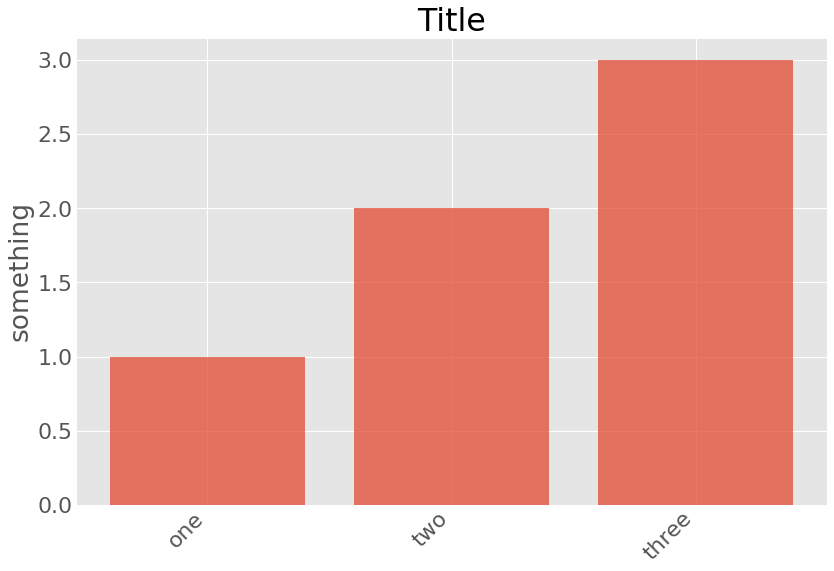

In [342]:
test = PlotFormatter()
x_labels = ['one','two','three']
y_vals = [1,2,3]
test.barchart(0,x_labels, y_vals, 'something','Title')
# fig, ax = plt.subplots(2)
# ax[1]